# RCT for ML Tools Synthetic Experiments

Code for synthetic simulations of randomized controlled trials for ML tools.



In [149]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Part 1: Define Data Generating Process

We consider each value of $X$ to be decreasing in the severity of patient illness.  Patients with a lower value of $X$ are more likely to develop a serious condition (the `disease_base_rate`).  The survival rate without alerts is determined by the `disease_base_rate` times the `survival_rate_if_disease_and_no_alert`, where it is assumed that all patients without disease survive.  

The impact of alerts varies by group.  For those where $X = 0$, it raises the survival rate among diseased patients from 40% to 60%, capturing a scenario where clinicians are already focusing on the sickest patients.  For those where $X > 0$, it increases the survival rate among the diseased patients from 10% (illustrating an exaggerated scenario where clinicians are less attentive) to 90%.  Note that these numbers apply to the scenario where $m = 1$, i.e., the model is perfectly accurate.

In [150]:
disease_base_rate = [0.9, 0.7, 0.6, 0.5]
survival_rate_if_disease_and_no_alert = [0.4, 0.1, 0.1, 0.1]
survival_rate_if_disease_and_alert = [0.6, 0.9, 0.9, 0.9]

In [151]:
survival_rate_no_alert = [
    d_rate * s_rate + (1 - d_rate) for d_rate, s_rate in zip(disease_base_rate, survival_rate_if_disease_and_no_alert)
]
survival_rate_alert = [
    d_rate * s_rate + (1 - d_rate) for d_rate, s_rate in zip(disease_base_rate, survival_rate_if_disease_and_alert)
]
causal_effect = [s_rate_alert - s_rate_no_alert for s_rate_alert, s_rate_no_alert in zip(survival_rate_alert, survival_rate_no_alert)]

In [152]:
for s in survival_rate_no_alert:
    print(round(s, 2))

0.46
0.37
0.46
0.55


In [153]:
for c in causal_effect:
    print(round(c, 2))

0.18
0.56
0.48
0.4


Finally, the effect of the alert is modulated by the accuracy $m$.  In particular, the "perfect accuracy" causal effect above is only achieved when $m = 1$, and is otherwise given by $0.5 + (m / 2)$ times that value.

In [154]:
# define the data generating process of Y, which is also a Bernoulli trial where the probability of success
# is defined as a function of x, a, and m below
def pY(x, a, m):
    p = survival_rate_no_alert[x]
    if a == 1:
        p += causal_effect[x] * (0.5 + m / 2)
    return p

In [155]:
# bar plots
def create_dgp_plots(objects, onset, survival, alert_survival):
    SMALL_SIZE = 10
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16

    plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure 

    bar_width = 0.4
    # positions for first cluster
    x = [1, 1.4, 1.8, 2.2]
    # Positions for second cluster
    x2 = [3.0, 3.4, 3.8, 4.2]

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 5))

    colors = ['#B8BBB7', '#6D6960', '#7F7F95', '#102542']
    colors_behind = ['#8D928B', '#363430', '#9B9BAB', '#306EC5']

    # Plot first cluster
    for i in range(len(objects)):
        ax.bar(x[i], onset[i], color=colors[i], width=bar_width)
    # Plot second cluster
    for i in range(len(objects)):
        ax.bar(x2[i], survival[i], color=colors[i], width=bar_width)
    # plot arrows and line at end of arrow
    for i in range(len(objects)):
        arrow_x = x2[i]
        arrow_start = survival[i]
        arrow_length = alert_survival[i] - survival[i]
        arrow_end = alert_survival[i]
        plt.arrow(x=arrow_x,
                  y=arrow_start,
                  dx=0, dy=arrow_length,
                  width=0.025, head_width=0.1, head_length=0.05,
                  length_includes_head=True,
                  color=colors[i]
        )
        plt.hlines(y=arrow_end,
                   xmin=arrow_x - 0.4/2,
                   xmax=arrow_x + 0.4/2,
                   color=colors[i],
                   linewidth=2
        )

    # Set x-axis labels
    ax.set_xticks(np.concatenate([x, x2]))
    ax.set_xticklabels(objects * 2, fontsize=14)

    # ax.set_ylim(0, 1)
    # set y ticks
    ax.set_yticks([i*0.1 for i in range(0, 11)])
    
    # Add labels for the two clusters
    mid_x1 = np.mean(x)  # Midpoint for first cluster
    mid_x2 = np.mean(x2)  # Midpoint for second cluster
    ax.text(mid_x1, -0.12, "Disease Prevalence", ha='center', fontsize=12, fontweight='bold')
    ax.text(mid_x2, -0.18, "Expected Survival Rate\n(With/Without Alerts)", ha='center', fontsize=12, fontweight='bold')
    # ax.text(2.5, -0.18, "$X$", ha='center', fontsize=16)

    # Labels and title
    ax.set_ylabel("Disease Onset/Expected Survival Rate", fontsize=14)

    plt.savefig('dgp_plot.pdf', bbox_inches='tight')

    # Show the plot
    plt.show()

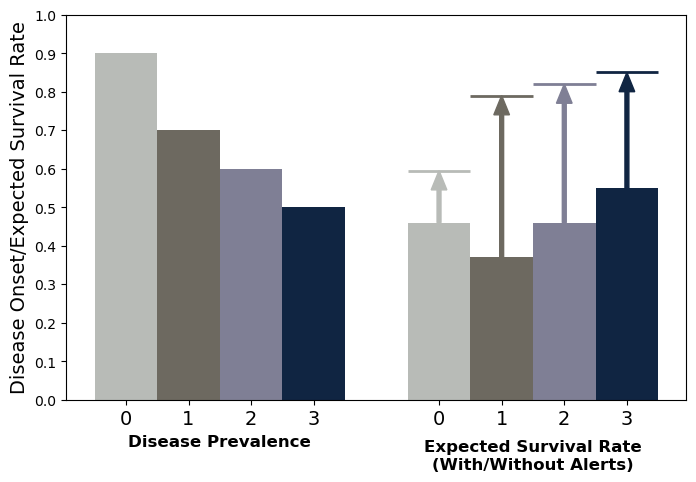

In [156]:
objects = ['0', '1', '2', '3']
onset = disease_base_rate
survival = survival_rate_no_alert
alert_survival = [pY(a = 1, x = i, m = 0.5) for i in range(len(onset))]

create_dgp_plots(objects, onset, survival, alert_survival)

# Part 2: Generate synthetic dataset.

In [157]:
def generate_data(n=5000):
    """
    Generate synthetic data for the experiments.
    Input:
    n: the size of the synthetic dataset

    Output:
    a pandas dataframe with the synthetic data
    """

    # generate a variable representing baseline patient covariates where
    # each category is assigned unformly at random
    X = np.random.choice([0,1,2,3], size=n, p=[1/4., 1/4., 1/4., 1/4.])

    # generate a variable to represent randomization to different cluster
    # 0 means control cluster, 1 means policy1, and 2 means policy2
    # assignment to clusters is uniformly at random
    D = np.random.choice([0,1,2], size=n, p=[1/3., 1/3., 1/3.])

    # define the behavior of policy 1
    def policy1(x):
        if x == 1:
            return 1
        else:
            return 0
    
    # define the behavior of policy 2
    def policy2(x):
        if x == 2 or x == 3:
            return 1
        else:
            return 0
        
    # define the behavior of policy e
    def policye(x):
        if x == 1 or x == 2 or x == 3:
            return 1
        else:
            return 0
        
    # define the behavior of policy e2
    def policye2(x):
        if x == 0 or x == 1:
            return 1
        else:
            return 0
    
    # generate the policy outputs for each patient covariate
    P0 = np.array([0 for x in X])
    P1 = np.array([policy1(x) for x in X])
    P2 = np.array([policy2(x) for x in X])
    Pe = np.array([policye(x) for x in X])
    Pe2 = np.array([policye2(x) for x in X])

    # generate whether the deployed model alerts, which is a deterministic function of D and the policy
    # that was deployed
    A = []
    for i in range(n):
        a = int(D[i] == 0)*0 + int(D[i] == 1)*P1[i] + int(D[i] == 2)*P2[i]
        A.append(a)

    # generate whether each patient experiences sepsis, which is defined as a Bernoulli trial
    # depending on the patient's covariates
    O = []
    for i in range(n):
        p = disease_base_rate[X[i]]
        O.append(np.random.binomial(1, p, 1)[0])
    O = np.array(O)

    # define model performance for each of the policies
    # model performance is deterministic based on the accuracy of the deployed model defined by D
    M = []
    for i in range(n):
        m = int(D[i] == 0)*round(np.mean(P0 == O), 2) + int(D[i] == 1)*round(np.mean(P1 == O), 2) + int(D[i] == 2)*round(np.mean(P2 == O), 2)
        M.append(m)

    Y = []
    for i in range(n):
        Y.append(np.random.binomial(1, pY(X[i], A[i], M[i]), size=1)[0])

    # compute the true effect of deploying P0 and print it
    effect_p0 = 0
    for x in [0,1,2,3]:
        a = 0
        effect_p0 += pY(x, a, round(np.mean(0 == O), 2))
    print('true effect of p0', effect_p0/4)

    # compute the true effect of deploying P1 and print it
    effect_p1 = 0
    for x in [0,1,2,3]:
        a = policy1(x)
        effect_p1 += pY(x, a, round(np.mean(P1 == O), 2))
    print('true effect of p1', effect_p1/4)

    # compute the true effect of deploying P1 and print it
    effect_p2 = 0
    for x in [0,1,2,3]:
        a = policy2(x)
        effect_p2 += pY(x, a, round(np.mean(P2 == O), 2))
    print('true effect of p1', effect_p2/4)

    # compute the true effect of deploying Pe and print it
    effect_pe = 0
    for x in [0,1,2,3]:
        a = policye(x)
        effect_pe += pY(x, a, round(np.mean(Pe == O), 2))
    print('true effect of pe', effect_pe/4)

    # compute the true effect of deploying Pe2 and print it
    effect_pe2 = 0
    for x in [0,1,2,3]:
        a = policye2(x)
        effect_pe2 += pY(x, a, round(np.mean(Pe2 == O), 2))
    print('true effect of pe2', effect_pe2/4)

    # combine the data to make the final dataframe
    data = pd.DataFrame({'X': X, 'D': D, 'P0': P0, 'P1': P1, 'P2': P2, 'Pe': Pe, 'Pe2': Pe2, 'A': A, 'Y': Y, 'M': M, 'O': O})

    return (data, effect_p0/4, effect_p1/4, effect_p2/4, effect_pe/4, effect_pe2/4)

In [158]:
def estimate_counterfactual(data, Pe, M_Pe, A, X, D, M, Y, Ymin, Ymax, a_0):
    """
    Input:
    data - a pandas dataframe containing the data
    Pe - string containing the name of the policy we want to evaluate
    M_Pe - the performance of the model Pe
    A - string containing the name of the variable for A
    X - string containing the name of the variable for X
    D - string containing the name of the variable for D
    M - string containing the name of the variable for M
    Y - string containing the name of the variable for Y
    Ymin - the minimum value for Y
    Ymax - the maximum value for Y
    a_0 - the value of the neutral action

    Output:
    a tuple containing the lower and upper bounds for the performance of the model Pe,
    if the performance is point identified, then the lower and upper bounds will have
    the same value
    """
    # get the unique values of X in the data
    X_values = np.unique(data[X])

    # get the unique values of D in the data
    D_values = np.unique(data[D])

    # define functions of X that return a set in domain of D for each value of x
    # define them as dictionaries since the domain of these functions is just the domain of X (0,1,2,3);
    # the key of the dictionary is the input to the function, and the value is the output of the function (a set in the domain of D)
    # we use D here instead of Pi, but using D and Pi here are equivalent as the value of D determines the value of Pi without 
    # any randomness
    Pi_leq = dict()
    tilde_Pi_leq = dict()
    Pi_geq = dict()
    tilde_Pi_geq = dict()
    Pi = dict()

    for x in X_values:
        # compute the output to the functions above for values of X=x
        data_subset_x = data[data[X] == x]

        cur_pi = set()
        cur_pi_leq = set()
        cur_pi_geq = set()

        for d in D_values:
            data_subset_xd = data_subset_x[data_subset_x[D] == d]

            # see if pi_d has the same model behavior as pi_e
            if list(data_subset_xd[A]) == list(data_subset_xd[Pe]):
                cur_pi.add(d)
            
            # see if pi_d has the same model behavior and less or equal performance
            if list(data_subset_xd[A]) == list(data_subset_xd[Pe]) and round(np.mean(data_subset_xd[M]), 2) <= M_Pe:
                cur_pi_leq.add((d, round(np.mean(data_subset_xd[M]), 2)))

            # see if pi_d has the same model behavior and greater or equal performance
            if list(data_subset_xd[A]) == list(data_subset_xd[Pe]) and round(np.mean(data_subset_xd[M]), 2) >= M_Pe:
                cur_pi_geq.add((d, round(np.mean(data_subset_xd[M]), 2)))

        Pi[x] = cur_pi
        Pi_leq[x] = set([x[0] for x in cur_pi_leq])
        Pi_geq[x] = set([x[0] for x in cur_pi_geq])

        if len(cur_pi_leq) != 0:
            tilde_Pi_leq[x] = set([max(cur_pi_leq, key=lambda x:x[1])[0]])
        else:
            tilde_Pi_leq[x] = set()
        if len(cur_pi_geq) != 0:
            tilde_Pi_geq[x] = set([min(cur_pi_geq, key=lambda x:x[1])[0]])
        else:
            tilde_Pi_geq[x] = set()

    # define a function that computes the probability that D is in a set d_set
    def p_D(d_set):
        return len(data[data[D].isin(d_set)]) / len(data)
    
    # define a special divide operation that prevents us from dividing by 0
    # we divide by 0 sometimes in the estimating functional but that doesn't hurt us because the indicator for that divide by 0
    # will be "turned off" anyways
    def special_divide(numerator, denominator):
        if denominator == 0:
            return 0
        else:
            return numerator/denominator
    
    # choose a critical value of 1.96 corresponding to 95% confidence intervals
    crit = 1.96

    # calculate the value of the target estimand for each row of data
    L_values = []
    for index, row in data.iterrows():
        L_values.append( int(row[Pe] != a_0) * int(len(tilde_Pi_leq[row[X]]) != 0) * row[Y] * (special_divide(int(row[D] in tilde_Pi_leq[row[X]]), p_D(tilde_Pi_leq[row[X]]))) \
                            + int(row[Pe] != a_0) * int(len(tilde_Pi_leq[row[X]]) == 0) * Ymin \
                            + int(row[Pe] == a_0) * int(len(Pi[row[X]]) != 0) * row[Y] * (special_divide(int(row[D] in Pi[row[X]]), p_D(Pi[row[X]]))) \
                            + int(row[Pe] == a_0) * int(len(Pi[row[X]]) == 0) * Ymin 
                            )
    lower_mean = np.mean(L_values)
    # compute confidence intervals for the lower bound value
    lower_se = np.std(L_values)/np.sqrt(len(data))
    lower_lowbound = lower_mean - (crit * lower_se)
    lower_upbound = lower_mean + (crit * lower_se)

    U_values = []
    for index, row in data.iterrows():
        U_values.append( int(row[Pe] != a_0) * int(len(tilde_Pi_geq[row[X]]) != 0) * row[Y] * (special_divide(int(row[D] in tilde_Pi_geq[row[X]]), p_D(tilde_Pi_geq[row[X]]))) \
                            + int(row[Pe] != a_0) * int(len(tilde_Pi_geq[row[X]]) == 0) * Ymax \
                            + int(row[Pe] == a_0) * int(len(Pi[row[X]]) != 0) * row[Y] * (special_divide(int(row[D] in Pi[row[X]]), p_D(Pi[row[X]]))) \
                            + int(row[Pe] == a_0) * int(len(Pi[row[X]]) == 0) * Ymax
                            )
    upper_mean = np.mean(U_values)
    # compute confidence intervals for the upper bound value
    upper_se = np.std(U_values)/np.sqrt(len(data))
    upper_lowbound = upper_mean - (crit * upper_se)
    upper_upbound = upper_mean + (crit * upper_se)

    return (lower_mean, upper_mean, lower_lowbound, upper_upbound)

In [159]:
np.random.seed(0)

(data, effect_p0, effect_p1, effect_p2, effect_pe, effect_pe2) = generate_data(5000)

print('model accuracy')
print('P0', np.mean(data['P0'] == data['O']))
print('P1', np.mean(data['P1'] == data['O']))
print('P2', np.mean(data['P2'] == data['O']))
print('Pe', np.mean(data['Pe'] == data['O']))
print('Pe2', np.mean(data['Pe2'] == data['O']))

print('model effect on outcome')
P0_effect = estimate_counterfactual(data, 'P0', round(np.mean(data['P0'] == data['O']), 2), 'A', 'X', 'D', 'M', 'Y', 0, 1, 0)
P1_effect = estimate_counterfactual(data, 'P1', round(np.mean(data['P1'] == data['O']), 2), 'A', 'X', 'D', 'M', 'Y', 0, 1, 0)
P2_effect = estimate_counterfactual(data, 'P2', round(np.mean(data['P2'] == data['O']), 2), 'A', 'X', 'D', 'M', 'Y', 0, 1, 0)
Pe_effect = estimate_counterfactual(data, 'Pe', round(np.mean(data['Pe'] == data['O']), 2), 'A', 'X', 'D', 'M', 'Y', 0, 1, 0)
Pe2_effect = estimate_counterfactual(data, 'Pe2', round(np.mean(data['Pe2'] == data['O']), 2), 'A', 'X', 'D', 'M', 'Y', 0, 1, 0)

print('P0', P0_effect[0], P0_effect[1])
print('P1', P1_effect[0], P1_effect[1])
print('P2', P2_effect[0], P2_effect[1])
print('Pe', Pe_effect[0], Pe_effect[1])
print('Pe2', Pe2_effect[0], Pe2_effect[1])

objects = [r'$\pi_0$', r'$\pi_1$', r'$\pi_2$', r'$\pi_{e0}$', r'$\pi_{e1}$']
performances = []
performances.append(np.mean(data['P0'] == data['O']))
performances.append(np.mean(data['P1'] == data['O']))
performances.append(np.mean(data['P2'] == data['O']))
performances.append(np.mean(data['Pe'] == data['O']))
performances.append(np.mean(data['Pe2'] == data['O']))

expected_outcomes = []
expected_outcomes.append(effect_p0)
expected_outcomes.append(effect_p1)
expected_outcomes.append(effect_p2)
expected_outcomes.append(effect_pe)
expected_outcomes.append(effect_pe2)

midpoints = [effect_p0, effect_p1, effect_p2, effect_pe, effect_pe2]
intervals = []
intervals.append((P0_effect[2], P0_effect[3]))
intervals.append((P1_effect[2], P1_effect[3]))
intervals.append((P2_effect[2], P2_effect[3]))
intervals.append((Pe_effect[2], Pe_effect[3]))
intervals.append((Pe2_effect[2], Pe2_effect[3]))

true effect of p0 0.46
true effect of p1 0.5601
true effect of p1 0.6096
true effect of pe 0.7246
true effect of pe2 0.6117000000000001
model accuracy
P0 0.3244
P1 0.4346
P2 0.3646
Pe 0.4748
Pe2 0.6354
model effect on outcome
P0 0.4614504485141956 0.4614504485141956
P1 0.5513351984996647 0.5513351984996647
P2 0.5982065907378064 0.5982065907378064
Pe 0.6880913407232754 0.8674
Pe2 0.4347351984996647 0.7546157706093191


In [160]:
print(midpoints)
intervals

[0.46, 0.5601, 0.6096, 0.7246, 0.6117000000000001]


[(0.4434905231431414, 0.47941037388524976),
 (0.5274621659742962, 0.5752082310250333),
 (0.5695795053662301, 0.6268336761093826),
 (0.6557187604669891, 0.8768005343378341),
 (0.41088831646064816, 0.7699679509085715)]

In [161]:
# bar plots
def create_bar_plots(objects, performances, expected_outcomes, intervals, midpoints):
    SMALL_SIZE = 10
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16

    plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure 

    bar_width = 0.4
    # positions for first cluster
    x = [1, 1.4, 1.8, 2.3, 2.7]
    # Positions for second cluster
    x2 = [3.5, 3.9, 4.3, 4.8, 5.2]

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 5))

    colors = ['#B8BBB7', '#6D6960', '#7F7F95', '#E09D00', '#CC77CE']

    # Plot first cluster
    for i in range(len(objects)):
        ax.bar(x[i], performances[i], color=colors[i], width=bar_width)
    # Plot second cluster
    for i in range(len(objects)):
        ax.bar(x2[i], expected_outcomes[i], color=colors[i], width=bar_width)

    # Set x-axis labels
    ax.set_xticks(np.concatenate([x, x2]))
    ax.set_xticklabels(objects * 2, fontsize=14)

    # ax.set_ylim(0, 1)
    # set y ticks
    ax.set_yticks([i*0.1 for i in range(0, 11)])
    
    # Add labels for the two clusters
    mid_x1 = np.mean(x)  # Midpoint for first cluster
    mid_x2 = np.mean(x2)  # Midpoint for second cluster
    ax.text(mid_x1, -0.12, "Accuracy", ha='center', fontsize=12, fontweight='bold')
    ax.text(mid_x2, -0.18, "Expected Survival Rate\n(Overall)", ha='center', fontsize=12, fontweight='bold')

    # Labels and title
    ax.set_ylabel("Accuracy/Expected Survival Rate", fontsize=14)

    error_bar_pos = [3.5, 3.9, 4.3, 4.8, 5.2]
    errors = []
    i = 0
    for interval in intervals:
        mid = midpoints[i]
        i += 1

        errors.append([[abs(mid - interval[0])],
                       [abs(mid - interval[1])]])
    print(errors)
    
    for i in range(len(error_bar_pos)):
        ax.errorbar(error_bar_pos[i], midpoints[i], yerr=errors[i], fmt=' ', color='b', ecolor='b', capsize=5, capthick=2, elinewidth=2)

    plt.savefig('sims.pdf', bbox_inches='tight')

    # Show the plot
    plt.show()

[[[0.016509476856858607], [0.019410373885249743]], [[0.03263783402570386], [0.015108231025033225]], [[0.04002049463376989], [0.017233676109382534]], [[0.06888123953301095], [0.1522005343378341]], [[0.20081168353935197], [0.15826795090857138]]]


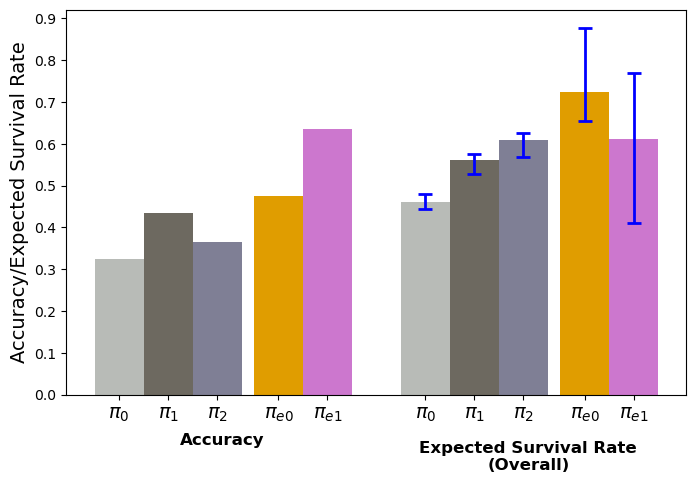

In [162]:
objects = [r'$\pi_0$', r'$\pi_1$', r'$\pi_2$', r'$\pi_{e0}$', r'$\pi_{e1}$']
create_bar_plots(objects, performances, expected_outcomes, intervals, midpoints)